In [1]:
#!/usr/bin/env pyhton3
# -*- coding 

from sklearn import datasets
from sklearn.model_selection import train_test_split
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
import gc

from sklearn.metrics import mean_squared_error,accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings('ignore')
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
# Global variables
inpDir = './input' # Input Stored here
outDir = './ouput' # output Here
modelDir = './models'# to save Models
subDir = 'text_gen' # sub dir by dataset
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
#rng = np.random.default_rng(seed = RANDOM_STATE)
#N_SAMPLE = 1000
TEST_SIZE = 0.2 # 18147 - 56*256
ALPHA = 0.001 # learning rate
NOISE = 0.2 # Error
EPOCHS = 30
BATCH_SIZE = 64 # default for tensorflow

PATIENCE = 10
LR_FACTOR = 0.1
LR_PATIENCE = 10

In [3]:
#set the plotting parameters
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }
    #'text.usetex':True,

plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


In [4]:
fileName = 'shakespeare.txt'
filePath = os.path.join(inpDir, subDir, fileName)

filePath

'./input\\text_gen\\shakespeare.txt'

In [5]:
text = open(filePath, 'rb').read().decode(encoding='utf-8')
len(text)

1115395

In [6]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


# character based modelling

In [8]:
vocab = sorted(set(text))
len(vocab)

65

In [9]:
char2idx = {u: i for i, u in enumerate(vocab)}
idx2char = np.array(vocab) #in array i can refer element by idx

In [10]:
text_as_int = np.array([char2idx [c] for c in text])
text_as_int.shape

(1115395,)

In [11]:
type(text_as_int)

numpy.ndarray

In [12]:
seq_length = 100
example_per_epoch = len(text) // (seq_length+1)
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(10):
    print(i.numpy(), end=':')
    
    print(idx2char[i.numpy()])
   

18:F
47:i
56:r
57:s
58:t
1: 
15:C
47:i
58:t
47:i


In [13]:
sequences = char_dataset.batch(seq_length +1, drop_remainder = True)
for item in sequences.take(2):
    print(item)
    print(repr(''.join(idx2char[item.numpy()])))

tf.Tensor(
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1], shape=(101,), dtype=int32)
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
tf.Tensor(
[39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39 58 46 43 56  1
 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47 57 46 12  0  0
 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53 50 60 43 42  8
  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47 56 57 58  6  1
 63 53 59  1 49], shape=(101,), dtype=int32)
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'


In [14]:
def split_input_target(chunk):
    input_text = chunk[:-1] # First hundred characters
    target_text = chunk[1:] # offset one as target
    return input_text, target_text
dataset = sequences.map(split_input_target)
dataset

<_MapDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.int32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None))>

In [15]:
for inp_ex, tar_ex in dataset.take(2):
    print(repr(''.join(idx2char[inp_ex.numpy()])))
    print(repr(''.join(idx2char[tar_ex.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you '
're all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'


In [16]:
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE,
                                            drop_remainder=True)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int32, name=None), TensorSpec(shape=(64, 100), dtype=tf.int32, name=None))>

In [17]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

In [18]:
def build_model(vocab_size, embedding_dim, 
                rnn_units, batch_size = BATCH_SIZE):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape = (None, ),
                              batch_size = batch_size),
        tf.keras.layers.Embedding(vocab_size,
                                  embedding_dim),
        tf.keras.layers.GRU(rnn_units, 
                            return_sequences=True, 
                           stateful=True,
                           recurrent_initializer='orthogonal',
                           kernel_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
                               ])


In [19]:
model = build_model(vocab_size, embedding_dim, rnn_units,
               BATCH_SIZE)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (64, None, 256)             │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (64, None, 1024)            │       3,938,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (64, None, 65)              │          66,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,021,569 (15.34 MB)

 Trainable params: 4,021,569 (15.34 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# unit testing :
# check for model's health without training

for inp_ex, tar_ex in dataset.take(1):
    ex_pred = model(inp_ex)

In [21]:
ex_pred.shape # batch size - embedding dim - probability

TensorShape([64, 100, 65])

In [22]:
# Why we sample

In [23]:
sample_indices = tf.random.categorical(ex_pred[0], num_samples = 1)
print(sample_indices.shape)

(100, 1)


In [24]:
sample_indices = tf.squeeze(sample_indices, axis= -1).numpy()
sample_indices

array([ 6,  7, 41, 15, 39, 39, 10, 36, 52, 19, 31, 43, 61, 16, 49,  3, 44,
        7,  5, 30, 43, 14, 16, 36, 21, 61, 53, 25, 64, 49, 53, 60, 27, 49,
       45, 35, 12, 53, 38, 26, 12, 35, 49,  1, 27, 58, 23, 59, 10, 15,  6,
       46, 43, 48, 57, 23, 60, 15, 32, 53, 21,  8,  1, 55, 52, 27, 56, 59,
       48, 55, 57,  0, 16, 47, 20, 36, 22, 55, 21, 55, 23, 30, 15, 32,  0,
       50, 22,  4, 46, 45, 63, 28,  3,  4, 56, 64, 11, 57, 43,  4],
      dtype=int64)

In [25]:
display(sample_indices)
print(repr(''.join(idx2char[sample_indices])))

array([ 6,  7, 41, 15, 39, 39, 10, 36, 52, 19, 31, 43, 61, 16, 49,  3, 44,
        7,  5, 30, 43, 14, 16, 36, 21, 61, 53, 25, 64, 49, 53, 60, 27, 49,
       45, 35, 12, 53, 38, 26, 12, 35, 49,  1, 27, 58, 23, 59, 10, 15,  6,
       46, 43, 48, 57, 23, 60, 15, 32, 53, 21,  8,  1, 55, 52, 27, 56, 59,
       48, 55, 57,  0, 16, 47, 20, 36, 22, 55, 21, 55, 23, 30, 15, 32,  0,
       50, 22,  4, 46, 45, 63, 28,  3,  4, 56, 64, 11, 57, 43,  4],
      dtype=int64)

",-cCaa:XnGSewDk$f-'ReBDXIwoMzkovOkgW?oZN?Wk OtKu:C,hejsKvCToI. qnOrujqs\nDiHXJqIqKRCT\nlJ&hgyP$&rz;se&"


In [26]:
# h_units = 100 # hidden layers No. of neurons
# input_shape = (1,10000) # inputs 

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Input(shape=input_shape))
# model.add(tf.keras.layers.SimpleRNN(units = h_units,
#                                    activation='tanh'
#                                    ))
# model.add(tf.keras.layers.Dense(1,
#                                    activation='linear',
                                   
#                                    ))

# model.summary()

In [27]:
#sample_indices = tf.squeeze(sample_indices, axis=1)

In [28]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)


In [29]:
model.compile(optimizer = 'adam', # optimisation, loss calculation 
             loss = loss_fn,
              metrics = ['accuracy']
             )


In [34]:
chkPtPath = os.path.join(modelDir, 'text_gen')
chkPtPrefix = os.path.join(chkPtPath, 'chkpt-{epoch}.keras')

chkpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath = chkPtPrefix )

In [36]:
history = model.fit(dataset, 
                    verbose = 1,
                    epochs =EPOCHS,
                    callbacks = [chkpt_callback]
                   )

Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 171s 985ms/step - accuracy: 0.4276 - loss: 1.9533
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 169s 973ms/step - accuracy: 0.5050 - loss: 1.6736
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 171s 989ms/step - accuracy: 0.5437 - loss: 1.5247
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 169s 975ms/step - accuracy: 0.5645 - loss: 1.4414
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 171s 986ms/step - accuracy: 0.5794 - loss: 1.3803
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.5904 - loss: 1.3392
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 167s 966ms/step - accuracy: 0.6006 - loss: 1.3017
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 166s 960ms/step - accuracy: 0.6103 - loss: 1.2643
Epoch 9/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 168s 967ms/step - accuracy: 0.6187 - loss: 1.2311
Epoch 10/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 168s 966ms/step - accuracy: 0.6261 - loss: 1.2024
Epoch 11/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 169s 975ms/step - accuracy: 0.6342 - loss: 1.1764
Epoch 12/30

In [37]:
loss_df = pd.DataFrame(history.history)

In [38]:
loss_df

,accuracy,loss
0,0.449627,1.873409
1,0.515966,1.633698
2,0.548339,1.507526
3,0.567236,1.431691
4,0.580066,1.379320
5,0.590865,1.338444
6,0.600007,1.303382
7,0.607560,1.272793
8,0.615781,1.242028
9,0.622839,1.214348


In [42]:
loss_df.loc[loss_df['loss'] ==loss_df['loss'].min()]

,accuracy,loss
29,0.797508,0.698999


IndexError: index 2 is out of bounds for axis 0 with size 2

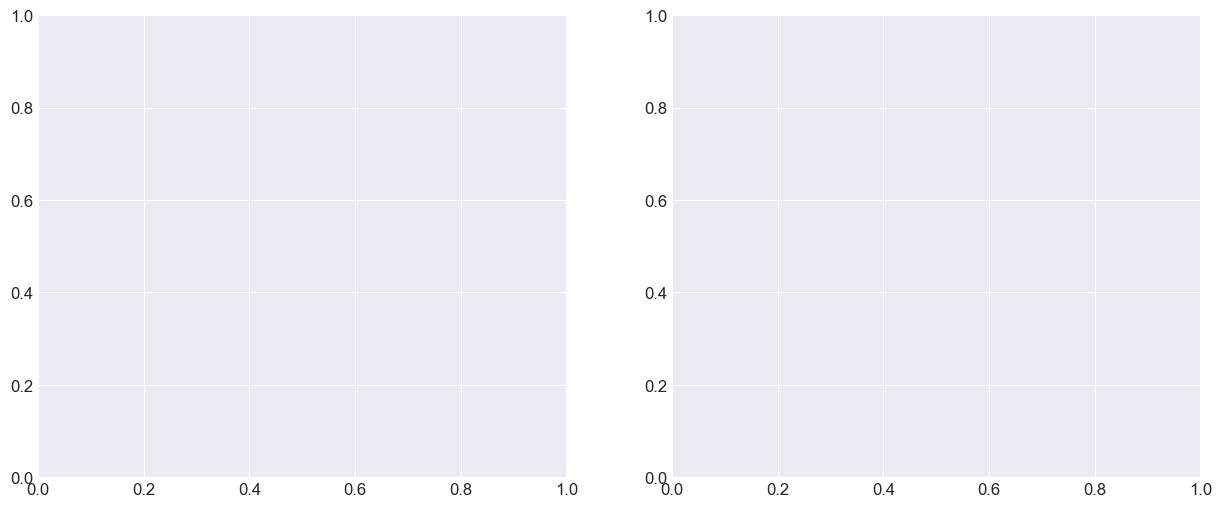

In [44]:
fn_plot_tf_hist(loss_df)

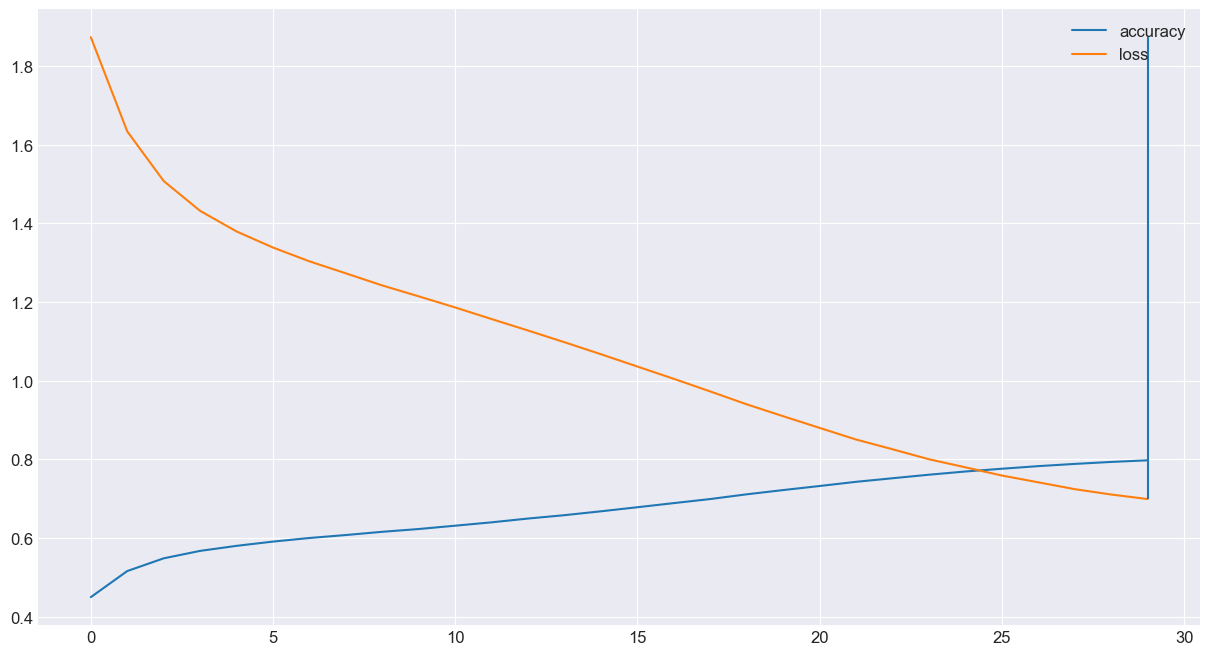

In [46]:
#ax = loss_df.plot()
ax = loss_df.plot()
ax.vlines(
    loss_df.loc[loss_df['loss'] ==loss_df['loss'].min()].index,
    ymin=loss_df.loc[loss_df['loss'] ==loss_df['loss'].min()].values[0][1],
    ymax=loss_df.loc[loss_df['loss'] ==loss_df['loss'].max()].values[0][1],
) 

In [ ]:
# ax.vlines(loss_df.loc[loss_df['loss']==loss_df['loss'].min()].index,
#          ymin = loss_df.loc[loss_df['loss'] == loss_df['loss'].min()].values[0][1],
#          ymax = loss_df.loc[loss_df['loss']== loss_df['loss'].max()].values[0][1])


In [ ]:
# !ls{chkPtPath}

In [48]:
modelNum = loss_df.loc[loss_df['loss'] == loss_df['loss'].min()].index.to_numpy()[0]

#modelNum = loss_df.loc[loss_df['loss'] == loss_df['loss'].max()].index.to_numpy()


In [54]:
chkpt_path = os.path.join(chkPtPath, f'chkpt-{modelNum}.keras')
chkpt_path

'./models\\text_gen\\chkpt-29.keras'

In [56]:
model1 = build_model(vocab_size, embedding_dim, rnn_units,
                    batch_size = 1) # Batch size =1 

model1.load_weights(chkpt_path)
model1.build(tf.TensorShape([1,None]))
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, None, 256)              │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (1, None, 1024)             │       3,938,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, None, 65)               │          66,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,021,569 (15.34 MB)

 Trainable params: 4,021,569 (15.34 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
def generate_text(model, start_string):
    num_generate = 1000
    # get indices for start string
    input_eval = [char2idx[s] for s in start_string] # list construct
    input_eval = tf.expand_dims(input_eval, 0) # tf.Tensor  with size (1,1,5)
    # store generated text
    text_generate = []
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions,0)
        # this is where rubber meets the road
        prediction_td = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        #add predicted value to inputs
        input_eval = tf.expand_dims([[prediction_td], 0])
        test_generate.append(idx2char[prediction_td])
    return start_string+''.join(text_generate)

In [ ]:
print(generate_text(model1, start_string=u'ROMEO:'))